# **1. Importar Librerías**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import random

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

import IPython.display as display
from PIL import Image
import io

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import os

Using TensorFlow backend.


# **2. Perfilamiento y Entendimiento de los Datos**

## **2.1. Lectura de los Datos**

Primero, se debe establecer la conexión con Google Drive donde se encuentran alojados los archivos TFRecord con las imágenes (se almacenan aquí por facilidad ya que son 15 archivos, y cada uno de ellos pesa cerca de 560 MB):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


A continuación, se define la siguiente función que permite permite listar los archivos TFRecord alojados en un directorio de Google Drive:

In [ ]:
#Función para cargar los archivos .tfrec desde un directorio del Drive
def list_tf_files_from_drive(path): 
  #tf_directory = '/tfrecords/' + os.sep + str(path)
    tf_directory = path
    #os.chdir(tf_directory)
    files = os.listdir()
    tffiles = list() 
    for file in files:
        if file.endswith(".tfrec"):
            tffiles.append(file)
    return tffiles

Ahora, se procede a realizar la lectura de los archivos TFRecord:

In [ ]:
tffiles1 = list_tf_files_from_drive('tfrecords/prueba/')
tffiles1[-1]

'train15-2061.tfrec'

In [ ]:
tffiles = tffiles1[:7]
tffiles

['train00-2071.tfrec',
 'train01-2071.tfrec',
 'train02-2071.tfrec',
 'train03-2071.tfrec',
 'train04-2071.tfrec',
 'train05-2071.tfrec',
 'train06-2071.tfrec']

Ahora, se definen las siguientes funciones que permiten leer los archivos TFRecord, y extraer las imagenes junto con su etiqueta o clase:

In [ ]:
# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def load_image_set(file):
    raw_image_dataset = tf.data.TFRecordDataset(file)
    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
    return parsed_image_dataset

#Funcion para obtener las imagenes y sus etiquetas desde los archivos .tfrec
def load_data(tffiles):
  X_benign = []
  y_benign = []
  X_melanoma = []
  y_melanoma = []

  for file in tffiles:
    records = load_image_set(file)
    for record in records:
      image_raw = record['image'].numpy()
      image = Image.open(io.BytesIO(image_raw))
      image = image.resize((256, 256))
      image = np.array(image)
      label = int(record['target'].numpy())
      
      if label == 0  :
        X_benign.append(image)
        y_benign.append(label)
      else:
        X_melanoma.append(image)
        y_melanoma.append(label)
    
  return np.array(X_benign), np.array(y_benign), np.array(X_melanoma), np.array(y_melanoma)

Luego, se cargan las imágenes y sus etiquetas o clases desde los archivos TFRecord encontrados anteriormente:

In [ ]:
%%time
X_benign, y_benign, X_melanoma, y_melanoma = load_data(tffiles)
print("X_benign: ", X_benign.shape)
print("y_benign: ", y_benign.shape)
print("X_melanoma: ", X_melanoma.shape)
print("y_melanoma: ", y_melanoma.shape)

X_benign:  (14254, 256, 256, 3)
y_benign:  (14254,)
X_melanoma:  (243, 256, 256, 3)
y_melanoma:  (243,)
Wall time: 16min 8s


## **2.2. Entendimiento de los Datos**

A continuación, se presenta de forma aleatoria una imágen de cada clase:

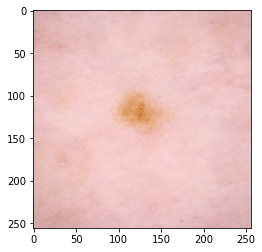

In [ ]:
i = random.randint(1, len(X_benign) - 1)
plt.imshow(X_benign[i])

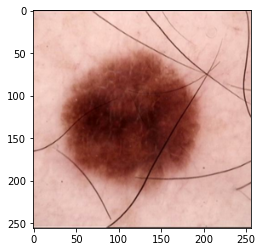

In [ ]:
i = random.randint(1, len(X_melanoma) - 1)
plt.imshow(X_melanoma[i])

En la siguiente gráfica, se puede observar la distribución de las imágenes con respecto a las dos clases obtenidas (0: Benign, 1: Melanoma):

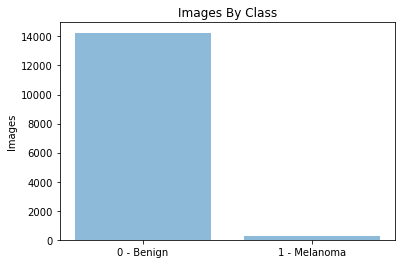

In [ ]:
labels = ('0 - Benign', '1 - Melanoma')
y_pos = np.arange(len(labels))
images = [len(y_benign), len(y_melanoma)]

plt.bar(y_pos, images, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Images')
plt.title('Images By Class')

plt.show()

# **3. Limpieza y Preparación de Datos**

## **3.1. Undersampling**

Como se evidencia en la gráfica anterior, los datos se encuentran altamente desbalanceados. Por esta razón, se procede a aplicar *undersampling* sobre la clase mayoritaria (0 - Benign):

A continuación, se define una función que permite aplicar *undersampling* a la clase mayoritaria:

In [ ]:
#Funcion que aplica indersampling sobre la clase mayoritaria
def apply_undersampling(X, y, n_images):
  X_undersampling = random.choices(X, k = n_images)
  y_undersamplig = random.choices(y, k = n_images)
  return np.array(X_undersampling), np.array(y_undersamplig)

Se aplica *undersampling* sobre la clase mayoritaria para mejorar el balance de los datos:

In [ ]:
i = int(X_melanoma.shape[0] * 6)
X_benign, y_benign = apply_undersampling(X_benign, y_benign, i)
print("X_benign: ", X_benign.shape)
print("y_benign: ", y_benign.shape)

X_benign:  (1458, 256, 256, 3)
y_benign:  (1458,)


Ahora, se define la siguiente función que permite unificar los conjuntos de datos de las dos clases obtenidas:

In [ ]:
#Funcion que crea un nuevo conjunto de datos uniendo los conjuntos de las dos clases
def unify_classes(X_1, y_1, X_2, y_2):
  X = []
  y = []

  for i in X_1:
    X.append(i)    
  
  for i in X_2:
    X.append(i)
    
  for i in y_1:
    y.append(i)

  for i in y_2:
    y.append(i)  

  return np.array(X), np.array(y)

Finalmente, se unifican los conjuntos de datos y se obtienen las variables `X` y `Y`:

In [ ]:
X, y = unify_classes(X_benign, y_benign, X_melanoma, y_melanoma)
print("X: ", X.shape)
print("y: ", y.shape)

X:  (1701, 256, 256, 3)
y:  (1701,)


## **3.1. Normalization**

A continuación, se hace la conversión del valor de los pixeles de cada imagen de 0 a 255, a valores entre 0 y 1:

In [ ]:
X = X / 255

## **3.3. Data Augmentation**

Con el fin de ayudar a mejorar el desbalance de los datos, y además la poca cantidad de imágenes de la clase minoritaria, se decide aplicar *data augmentartion*.

Primero, se realiza la separación de los datos en el conjunto de datos de entrenamiento y el de validación:

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.5, random_state=33)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_validation: ", X_validation.shape)
print("y_validation: ", y_validation.shape)

X_train:  (850, 256, 256, 3)
y_train:  (850,)
X_validation:  (851, 256, 256, 3)
y_validation:  (851,)


A continuación, se instancia la función que permite aplicar la aumentación de imágenes:

In [ ]:
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             #zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

Ahora, se define la siguiente función que permite realizar la aumentación de imágenes de la clase minoritaria (1 - Melanoma):

In [ ]:
def apply_data_augmentation(data_generator, X, y, n_images):
  X_list = []
  y_list = []
  
  for i in range(len(X)):
    if y[i] == 1:
      X_list.append(X[i])
      y_list.append(1)
      
      X_image = img_to_array(X[i]) 
      X_image = X_image.reshape((1,) + X_image.shape)  

      n = 1
      for batch in data_generator.flow(X_image, batch_size=1):
        X_list.append(batch[0])
        y_list.append(1)
        
        n = n + 1
        if n > n_images:
          break
                
    else:
      X_list.append(X[i])
      y_list.append(0)

  return np.array(X_list), np.array(y_list)    

Finalmente, se obtiene un nuevo conjunto de datos de entrenamiento más balanceado y con mayor númeo de imágenes pertenecientes a la clase minoritaria (1 - Melanoma) despues de haber aplicado la aumentación de imágenes:

In [ ]:
X_train , y_train = apply_data_augmentation(datagen, X_train, y_train, 10)
print(X_train.shape)
print(y_train.shape)

(2020, 256, 256, 3)
(2020,)


# **4. Modelamiento**

Ahora, se define la siguiente función que permite construir la red neuronal convolucional:

In [ ]:
def build_convolutional_model(hidden_conv_layers, input_filters, hidden_filters, dropout, output_activation):
  input = (256, 256, 3)
  output = 2
  kernel = (2, 2)

  conv_model = Sequential(name='hcl_{0}_if_{1}_hf_{2}_d_{3}_oa_{4}'.format(hidden_conv_layers, input_filters, hidden_filters, dropout, output_activation))
  
  conv_model.add(Conv2D(filters=input_filters, kernel_size=kernel, strides=(1,1), padding='same', input_shape=input, data_format='channels_last'))
  conv_model.add(Activation('relu'))
  conv_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  
  if hidden_conv_layers > 0:
    for i in range(hidden_conv_layers):
      conv_model.add(Conv2D(filters=hidden_filters, kernel_size=kernel, strides=(1,1), padding='valid'))
      conv_model.add(Activation('relu'))
      conv_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  conv_model.add(Flatten())    
  conv_model.add(Dense(256))
  conv_model.add(Activation('relu'))
  conv_model.add(Dropout(dropout))

  conv_model.add(Dense(output))
  conv_model.add(Activation(output_activation))

  conv_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
  return conv_model

Se instancia el modelo de clasificación que se creará a partir de la función anterior:

In [ ]:
model = KerasClassifier(build_fn=build_convolutional_model, epochs=20, verbose=1, shuffle=True)

A continuación, se definen los hiperparámetros que se van a iterar con la función `RandomizedSearchCV`:

In [ ]:
param_grid = dict(hidden_conv_layers = [2, 3],
                  input_filters = [16, 32, 64],
                  hidden_filters = [32, 64, 128],
                  dropout = [0.1, 0.3, 0.5, 0.7, 0.9],
                  output_activation = ['sigmoid'])

Se define la siguiente función de pérdida:

In [ ]:
def loss_function(y_true, y_pred):
  return accuracy_score(y_true.argmax(axis=-1), y_pred)

In [ ]:
score = make_scorer(loss_function, greater_is_better=True)

Se instancia la función `RandomizedSearchCV` que realizará la iteración de los hiperparámetros:

In [ ]:
randomized_search = RandomizedSearchCV(model, param_grid, scoring=score, verbose=1, cv = 3, n_iter=3, random_state=20,n_jobs=-1)

Se inicia la iteración de hiperparámetros:

In [ ]:
%%time
randomized_search_grid = randomized_search.fit(X_train, tf.keras.utils.to_categorical(y_train, 2))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 343.5min finished


Epoch 1/20
2020/2020 [==============================] - 104s 51ms/step - loss: 0.6601 - accuracy: 0.6849
Epoch 2/20
2020/2020 [==============================] - 99s 49ms/step - loss: 0.5921 - accuracy: 0.7193
Epoch 3/20
2020/2020 [==============================] - 99s 49ms/step - loss: 0.5660 - accuracy: 0.7351
Epoch 4/20
2020/2020 [==============================] - 99s 49ms/step - loss: 0.5300 - accuracy: 0.7554
Epoch 5/20
2020/2020 [==============================] - 98s 49ms/step - loss: 0.5084 - accuracy: 0.7696
Epoch 6/20
2020/2020 [==============================] - 98s 49ms/step - loss: 0.4603 - accuracy: 0.7899
Epoch 7/20
2020/2020 [==============================] - 99s 49ms/step - loss: 0.4359 - accuracy: 0.7958
Epoch 8/20
2020/2020 [==============================] - 99s 49ms/step - loss: 0.4044 - accuracy: 0.8062
Epoch 9/20
2020/2020 [==============================] - 99s 49ms/step - loss: 0.3778 - accuracy: 0.8386
Epoch 10/20
2020/2020 [==============================] - 98s 49

A continuación, se presenta el mejor modelo obtenido a partir de las iteraciones realizadas:

In [ ]:
best_model = randomized_search_grid.best_estimator_
best_model.model.summary()

Model: "hcl_3_if_16_hf_64_d_0.1_oa_sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 16)      208       
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 127, 127, 64)      4160      
_________________________________________________________________
activation_8 (Activation)    (None, 127, 127, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (No

Debido a los altos requerimientos de capacidad de cómputo necesarios para modelar redes neuronales convolucionales (CNN) al trabajar con imágenes, se configuran pocas iteraciones sobre la función `RandomizedSearchCV` con el fin de obtener una aproximación de un mejor modelo.

Como resultado de la iteración, se obtiene como mejor estimador, un modelo con 3 capas convolucionales ocultas, que aplica 16 filtros en su capa de entrada, y 64 filtros en las capas convolucionales ocultas, además de incluir un dropout de 0.1, y una función de activación sigmoide para la capa densa de salida.

# **5. Predicción**

A continuación, se obtienen las predicciones del modelo para el conjunto de datos de validación:

In [ ]:
model_predictions = best_model.predict(X_validation)
model_predictions

851/851 [==============================] - 15s 18ms/step


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,

# **6. Validación**

Primero, se obtienen los indices de las imágenes que fueron clasificadas correctamente, y tambien aquellas donde el modelo se equivocó:

In [ ]:
model_correct_indexes = np.nonzero(model_predictions == y_validation)[0]
model_incorrect_indexes = np.nonzero(model_predictions != y_validation)[0]

En la siguiente gráfica, se presentan algunas de las imágenes que el modelo clasificó correctamente:

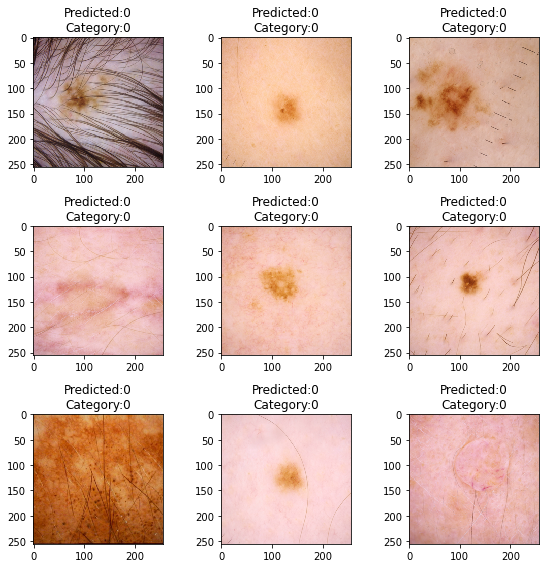

In [ ]:
plt.figure(figsize=(8,8))

for i, correct in enumerate(model_correct_indexes[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_validation[correct], cmap='gray', interpolation='none')
    plt.title("Predicted:{}\nCategory:{}".format(model_predictions[correct], y_validation[correct]))

plt.tight_layout()

En la siguiente gráfica, se presentan algunas de las imágenes que el modelo clasificó de forma incorrecta:

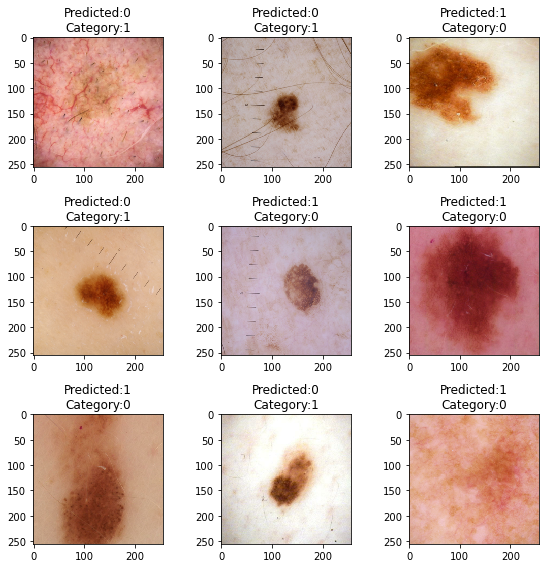

In [ ]:
plt.figure(figsize=(8,8))

for i, incorrect in enumerate(model_incorrect_indexes[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_validation[incorrect], cmap='gray', interpolation='none')
    plt.title("Predicted:{}\nCategory:{}".format(model_predictions[incorrect], y_validation[incorrect]))

plt.tight_layout()

Ahora, se presenta el reporte de clasificación obtenido para el modelo:

In [ ]:
print(classification_report(y_validation, model_predictions))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       725
           1       0.36      0.63      0.46       126

    accuracy                           0.78       851
   macro avg       0.64      0.72      0.66       851
weighted avg       0.84      0.78      0.80       851



Finalmente, se presenta la matriz de confusión del modelo:

<AxesSubplot:>

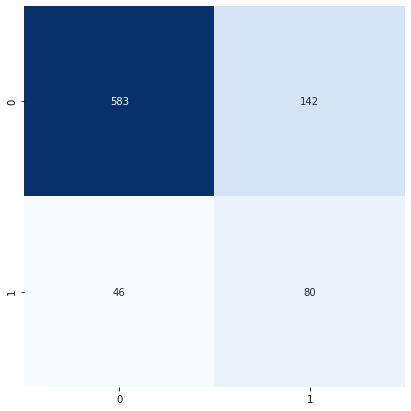

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_validation, model_predictions)

df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y_validation)], columns = [i for i in np.unique(y_validation)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)

# **7. Análisis de Resultados**

Teniendo en cuenta las métricas obtenidas en el reporte de clasificación y en la matriz de confusión del modelo, se puede concluir lo siguiente:

- La aplicación del *undersampling* para mejorar el balance de los datos, ayudó a evitar el sesgo en el modelo a causa de la gran cantidad de imágenes pertenecientes a la clase mayoritaria. Sin embargo, al tener muy pocos datos de la clase minoritaria, el modelo no logra aprender correctamente las principales caracteristicas de cada clase ya que el conjunto de datos se reduce considerablemente.
- La aplicación de un mecanismo de *data augmentation* para mejorar el balance de los datos e incrementar la cantidad de imágenes de la clase minoritaria para poder entrenar el modelo con mayor número de datos, permitió al modelo aprender de mejor manera las caracteristicas principales de cada clase, y esto se ve reflejado en el incremento de la métrica de `accuaracy` del modelo.
- Los altos requerimientos de capacidad de cómputo en términos de memoria y procesamiento principalmente, no permitieron validar el comportamiento de los modelos con la totalidad del conjunto de datos (se utilizaron 7 de 15 folds) e incrementar la cantidad de iteraciones realizadas por la función `RandomizedSearchCV`, con el fin de obtener una mejor aproximación de un mejor modelo.
- Aunque la métrica de `accuaracy` alcanzó un 78%, lo cual es una métrica aceptable, al analizar detalladamente el comportamiento del modelo se puede observar que aunque la precisión para la clase 'Benign' es de 93%, también presenta un recall de 80%, lo que quiere decir que aunque la mayor parte de las imágenes pertenecientes a la clase 'Benign' se clasificaron correctamente, tambien un gran número de imágenes pertenecientes a la clase 'Melanoma' se clasificaron como parte de la clase 'Benign'. Interpretando esto en términos del negocio, significa que la mayor parte de las lesiones 'Benignas' se clasificarían correctamente, pero también un gran número de lesiones malignas o 'Melanomas' serían clasificadas como 'Benignas', lo cual resultaría peligroso ya que muchas lesiones que requeririan de atención y tratamiendo médico y que podrían ser mortales, se estimarían como benignas. Por otro lado, al analizar las métricas de la clase 'Melanoma', se obtuvo una precisión del 36% que es demasiado baja, tambien se presenta un recall de 63%, lo que se traduce en un bajo rendimiento del modelo para detectar lesiones malignas o 'Melanomas', y además, un alta probabilidad de que una lesión clasificada como maligna en realidad sea 'Beningna'.
- En términos generales, no se considera un buen modelo de clasificación de imágenes de lesiones benignas y melanomas, principalmente, por la baja precisión del modelo (36%) para detectar 'Melanomas', y el alto recall (80%) de la clase 'Benign', ya que el propósito del modelo para el negocio sería detectar con alta precisión la lesiones malignas o melanomas para que estas puedan ser diagnosticadas y tratadas a tiempo, pero sin incurrir en un estudio profundo de gran parte de lesiones benignas que puedan ser consideradas o confundidas con lesiones malignas.